<h1>Curve Fitting Model for Covid-19 Prediction</h1>

<p>This model uses an almost identical baseline model to the provided benchamrk erf model. It includes a few optimizations that improve its performance, especially on the larger counties. These improvements are:</p>

• Multiplying predictions for NYC by 3 (weird, I know, but it works) <br>
• When generating quantiles for a value, assume a constant difference between each quantile level <br>
• For counties with fewer than 50 total deaths, predict all zeros (also seems weird)

<p>We cannot use this model for a submission because it is so close to the benchmark model, and the improvements made do not represent actual machine learning techniques, just slight tweaks to the results</p>

In [1]:
from scipy.special import erf
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import time

import pandas as pd
from util import util

<h1>Global Dataframes and Variables</h1>

In [2]:
# We import the sample_submission.csv file as a way of determining
# the order of the rows in out output file
sample_submission = pd.read_csv("../sample_submission.csv")

# The fips_key.csv file contains standard information about each county
key = pd.read_csv("../data/us/processing_data/fips_key.csv", encoding='latin-1')

# Daily deaths contains the death count per day for each county.
# Cumulative deaths contains the total death count for each county
# by day.
daily_deaths = pd.read_csv("../data/us/covid/nyt_us_counties_daily.csv")
cumulative_deaths = pd.read_csv("../data/us/covid/deaths.csv")
county_land_areas = pd.read_csv("../data/us/demographics/county_land_areas.csv", encoding='latin1')
county_population = pd.read_csv("../data/us/demographics/county_populations.csv", encoding='latin1')
mobility_data = pd.read_csv("../data/us/mobility/DL-us-m50.csv", encoding='latin1')

# List of all counties
all_fips = key["FIPS"].tolist()

util = util(daily_deaths, cumulative_deaths, county_land_areas, county_population, mobility_data, key)

<h1>Functions Used for Curve Fitting</h1>

In [3]:
def erf_curve(times, log_max, slope, center):
    max_val = 10 ** log_max
    deaths = max_val * (1 + erf(slope * (times - center)))
    return deaths

def linear_curve(times, slope, intercept):
    return [x * slope for x in times] + intercept

def constant_curve(times, c):
    return [x * c for x in times]

<h1>Helper Functions for Producing a Submission</h1>

In [4]:
def make_predictions(fips, startDate, endDate, n_steps):
    # Use the daily deaths list to compute a list of the cumulative deaths.
    # This is better than directly accessing cumulative deaths because
    # the NY data is faulty, so we can directly replace the daily deaths
    # much more easily
    
    daily_deaths_list = util.get_deaths_list(fips, endDate=endDate)
    
    #if len(daily_deaths_list) > 0 and daily_deaths_list[-1] > 20:
    #    remove_portion = int(0.5 * len(daily_deaths_list))
    #    daily_deaths_list = daily_deaths_list[remove_portion:]
    
    cumulative_deaths_list = []

    curr = 0
    for i in range(len(daily_deaths_list) - 1):
        curr += daily_deaths_list[i]
        cumulative_deaths_list.append(curr)
    
    # Compute x and y lists to pass to curve_fit
    x = [i for i in range(len(cumulative_deaths_list))]
    y = cumulative_deaths_list
    
    if len(cumulative_deaths_list) < 20 or y[-1] < 50:
        return [0] * n_steps
    
    x_input = [i + len(cumulative_deaths_list) for i in range(n_steps + 1)]
    popt, pcov = curve_fit(erf_curve, x, y, maxfev=10000)
    output = erf_curve(x_input, popt[0], popt[1], popt[2])
    
    # Difference predictions to get daily deaths
    predictions = np.diff(output)
    
    # Multiply predictions for NY by 3
    #if fips == 36061:
    #    for i in range(len(predictions)):
    #        predictions[i] = predictions[i] * 3
    
    return predictions

def generate_quantiles(value):
    quantiles = []
    for i in range(-4, 5):
        quantiles.append(value + value * 0.2 * i)

    return quantiles

def get_id_list():
    return sample_submission["id"].values

def extract_fips_from_id(row_id):
    return row_id.split('-')[-1]

def extract_date_from_id(row_id):
    split = row_id.split('-')
    return '-'.join(split[:-1])

<h1>Place the Data into a Dictionary for Easy Access</h1>

In [11]:
#dates_of_interest = ["2020-05-08", "2020-05-09", "2020-05-10", "2020-05-11",
#                     "2020-05-12", "2020-05-13", "2020-05-14", "2020-05-15", "2020-05-16", "2020-05-17", "2020-05-18", \
#                    "2020-05-19", "2020-05-20", "2020-05-21", "2020-05-22", "2020-05-23", "2020-05-24", "2020-05-25", "2020-05-26", "2020-05-27"]

#dates_of_interest = ["2020-05-10", "2020-05-11", "2020-05-12", "2020-05-13", "2020-05-14", "2020-05-15", "2020-05-16", \
#                     "2020-05-17", "2020-05-18", "2020-05-19", "2020-05-20", "2020-05-21", "2020-05-22", "2020-05-23", \
#                     "2020-05-24", "2020-05-26", "2020-05-27", "2020-05-28"]

#dates_of_interest = ["2020-05-01", "2020-05-02", "2020-05-03", "2020-05-04", "2020-05-05", "2020-05-06", "2020-05-07", \
#                     "2020-05-08"]

dates_of_interest = ["2020-05-25", "2020-05-26", "2020-05-27", "2020-05-28", "2020-05-29", "2020-05-30", "2020-05-31", \
                     "2020-06-01", "2020-06-02", "2020-06-03", "2020-06-04", "2020-06-05", "2020-06-06", "2020-06-07", \
                     "2020-06-08", "2020-06-09", "2020-06-10", "2020-06-11", "2020-06-12", "2020-06-13", "2020-06-14"]

data = {}
for fips in all_fips:
    data[fips] = {}
    predictions = make_predictions(fips, "2020-03-30", "2020-05-24", 21)
    
    for i, date in enumerate(dates_of_interest):
        data[fips][date] = generate_quantiles(predictions[i])

<h1>Export the Submission to a CSV for Scoring</h1>

In [12]:
lists = []
for row_id in get_id_list():
    date = extract_date_from_id(row_id)
    fips = int(extract_fips_from_id(row_id))
    
    if not fips in data:
        lst = [row_id] + ["%.2f" % 0.00] * 9
        lists.append(lst)
        continue
        
    if not date in data[fips]:
        lst = [row_id] + ["%.2f" % 0.00] * 9
        lists.append(lst)
        continue
    
    quantiles = data[fips][date]
    lst = [row_id]

    for q in quantiles:
        if str(q) == "nan":
            lst.append("%.2f" % 0.00)
        elif q < 0:
            lst.append("%.2f" % 0.00)
        else:
            lst.append("%.2f" % q)
            
    lists.append(lst)
    
df = pd.DataFrame(lists, columns=sample_submission.columns)
df.to_csv("../Residual Neural Net/curve_for_residuals_train.csv", index=False, sep=',')

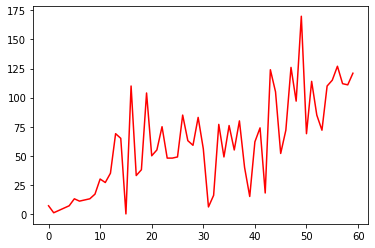

In [16]:
util.plot_list(util.get_cases_list(6059, "2020-05-11")[-60:])

In [5]:
age_data = pd.read_csv("../data/us/advanced_age_data/PEP_2018_PEPAGESEX_with_ann.csv", encoding='latin1', low_memory=False)

In [6]:
column_weight_map = {
    "est72017sex0_age0to4": 0,
    "est72017sex0_age5to9": 0,
    "est72017sex0_age10to14": 0.2,
    "est72017sex0_age15to19": 0.2,
    "est72017sex0_age20to24": 0.2,
    "est72017sex0_age25to29": 0.2,
    "est72017sex0_age30to34": 0.2,
    "est72017sex0_age35to39": 0.2,
    "est72017sex0_age40to44": 0.4,
    "est72017sex0_age45to49": 0.4,
    "est72017sex0_age50to54": 1.3,
    "est72017sex0_age55to59": 1.3,
    "est72017sex0_age60to64": 3.6,
    "est72017sex0_age65to69": 3.6,
    "est72017sex0_age70to74": 8.0,
    "est72017sex0_age75to79": 8.0,
    "est72017sex0_age80to84": 14.8,
    "est72018sex2_age85plus": 14.8
}

total_pop = 0
FIPS = "36061"

for name in column_weight_map:
    total_pop += int(age_data.loc[age_data["GEO.id2"] == FIPS][name].values[0])
    
death_rate = 0
for name in column_weight_map:
    pop = int(age_data.loc[age_data["GEO.id2"] == FIPS][name].values[0])
    death_rate += (pop / total_pop) * column_weight_map[name]

print(death_rate)

1.7671050938629678


In [12]:
pop = int(age_data.loc[age_data["GEO.id2"] == FIPS]["est72017sex0_age80to84"].values[0])
pop += int(age_data.loc[age_data["GEO.id2"] == FIPS]["est72017sex0_age85plus"].values[0])
print((pop / total_pop) * total_pop)

71660.0


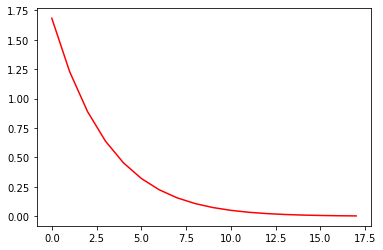

In [13]:
preds = make_predictions(36061, "2020-03-30", "2020-05-22", 18)
util.plot_list(preds)

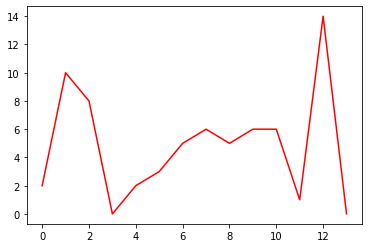

[ 2. 10.  8.  0.  2.  3.  5.  6.  5.  6.  6.  1. 14.  0.]


In [18]:
fips = 48113

util.plot_list(util.get_deaths_list(fips, endDate="2020-05-20")[-14:])
print(util.get_deaths_list(fips, endDate="2020-05-20")[-14:])